In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np
import os

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


In [4]:
load_dotenv('../.env') # Ajusta la ruta según donde esté tu notebook

DATABASE_URL = os.getenv("DATABASE_URL")
# Nombre del esquema del cliente del que quieres predecir las ventas.
# En django-tenants, cada tienda tiene su propio esquema.
TENANT_SCHEMA = 'pepita' # CAMBIA ESTO por el nombre real de tu esquema (ej: 'google', 'pepita', etc.)

if not DATABASE_URL:
    raise ValueError("¡No se encontró la DATABASE_URL!")

try:
    # Conectamos a la base de datos
    engine = create_engine(DATABASE_URL)
    
    # Probamos la conexión y establecemos el search_path para apuntar al inquilino correcto
    with engine.connect() as connection:
        connection.execute(text(f"SET search_path TO {TENANT_SCHEMA}"))
        print(f"Conexión establecida al esquema: {TENANT_SCHEMA}")
        
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")

Conexión establecida al esquema: pepita


In [8]:
# Nota: En SQL, para usar el search_path definido, ejecutamos todo en una conexión
query_str = f"""
    SELECT 
        DATE(fecha_creacion) as fecha, 
        SUM(total) as total_ventas
    FROM 
        pedidos_pedido
    WHERE 
        estado IN ('pagado', 'enviado', 'entregado')
    GROUP BY 
        DATE(fecha_creacion)
    ORDER BY 
        fecha;
"""

try:
    with engine.connect() as connection:
        # Importante: Setear el schema antes de la query
        connection.execute(text(f"SET search_path TO {TENANT_SCHEMA}"))
        
        df_ventas = pd.read_sql(text(query_str), connection, index_col='fecha', parse_dates=True)
        
    # Rellenar días sin ventas con 0 para mantener la continuidad temporal
    df_ventas = df_ventas.asfreq('D', fill_value=0)
    
    print(f"Datos cargados del esquema '{TENANT_SCHEMA}'. Total de días: {len(df_ventas)}")
    print("\nÚltimos 5 días de datos:")
    print(df_ventas.tail())

except Exception as e:
    print(f"Error al ejecutar la query. Verifica que el esquema '{TENANT_SCHEMA}' exista y tenga la tabla 'pedidos_pedido'.")
    print(f"Detalle: {e}")

Datos cargados del esquema 'pepita'. Total de días: 1

Últimos 5 días de datos:
            total_ventas
fecha                   
2025-11-19         400.0


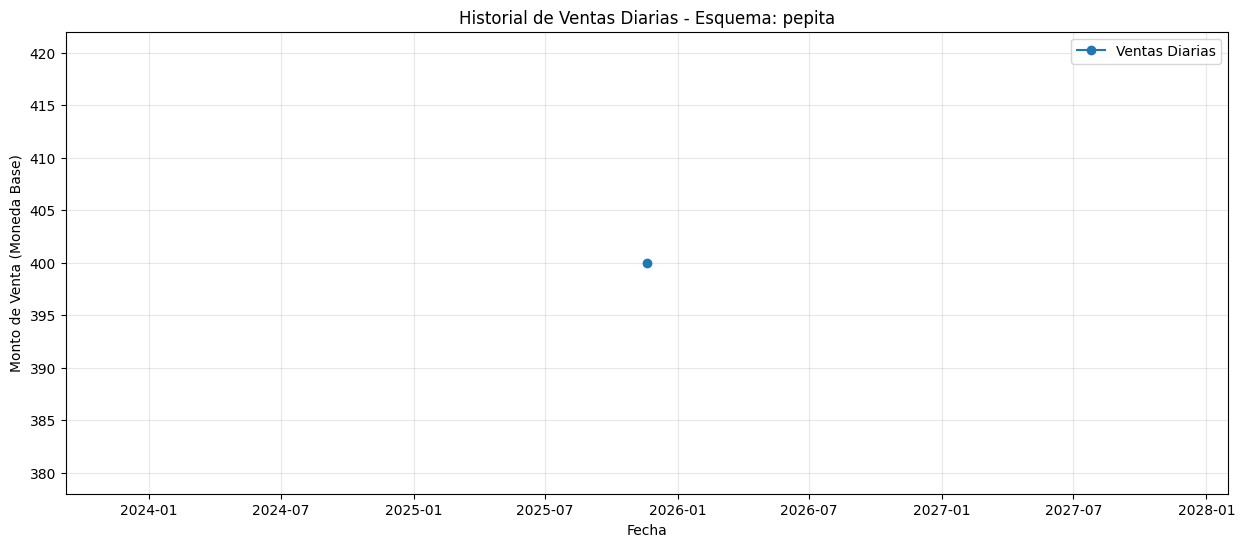

In [9]:
if not df_ventas.empty:
    plt.figure(figsize=(15, 6))
    plt.plot(df_ventas['total_ventas'], label='Ventas Diarias', marker='o')
    plt.title(f'Historial de Ventas Diarias - Esquema: {TENANT_SCHEMA}')
    plt.xlabel('Fecha')
    plt.ylabel('Monto de Venta (Moneda Base)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No hay datos para graficar.")

In [14]:
def crear_features(df):
    """Crea características de series de tiempo a partir de un índice de fecha."""
    df_copy = df.copy()
    df_copy['dia_del_mes'] = df_copy.index.day
    df_copy['dia_de_la_semana'] = df_copy.index.dayofweek  # Lunes=0, Domingo=6
    df_copy['mes'] = df_copy.index.month
    df_copy['anio'] = df_copy.index.year
    df_copy['trimestre'] = df_copy.index.quarter
    
    # Lag features (ventas pasadas)
    df_copy['ventas_dia_anterior'] = df_copy['total_ventas'].shift(1)
    
    # Rolling features (tendencias)
    df_copy['media_ventas_7_dias'] = df_copy['total_ventas'].shift(1).rolling(window=7).mean()
    
    # Limpieza de NaN generados por shift y rolling
    df_copy = df_copy.fillna(0)
    
    return df_copy

if not df_ventas.empty:
    df_features = crear_features(df_ventas)
    print("Datos con nuevas características (features):")
    print(df_features.tail())
else:
    print("Dataframe vacío, no se pueden crear features.")

Datos con nuevas características (features):
            total_ventas  dia_del_mes  dia_de_la_semana  mes  anio  trimestre  \
fecha                                                                           
2025-11-19         400.0           19                 2   11  2025          4   

            ventas_dia_anterior  media_ventas_7_dias  
fecha                                                 
2025-11-19                  0.0                  0.0  


In [15]:
if not df_ventas.empty:
    TARGET = 'total_ventas'
    FEATURES = [col for col in df_features.columns if col != TARGET]

    X = df_features[FEATURES]
    y = df_features[TARGET]

    # División temporal (Shuffle=False es vital aquí)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    print(f"Total de días: {len(X)}")
    print(f"Días para entrenar: {len(X_train)}")
    print(f"Días para probar: {len(X_test)}")

    # Instancia y entrenamiento
    modelo = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    print("\nEntrenando el modelo...")
    modelo.fit(X_train, y_train)
    print("¡Modelo entrenado!")

    # Evaluación
    score = modelo.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, modelo.predict(X_test)))
    
    print(f"\nPuntuación del modelo (R-squared): {score:.2f}")
    print(f"Error cuadrático medio (RMSE): {rmse:.2f}")
else:
    print("No hay datos para entrenar.")

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [11]:
if 'modelo' in locals():
    # Crear directorio si no existe
    output_dir = '../modelo'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Carpeta creada: {output_dir}")

    ruta_guardado = os.path.join(output_dir, f'modelo_rf_{TENANT_SCHEMA}.pkl')

    joblib.dump(modelo, ruta_guardado)

    print(f"¡Modelo guardado exitosamente en: {ruta_guardado}")
else:
    print("No hay modelo para guardar.")

No hay modelo para guardar.
